# Notebook to generate psychometrics plot given sessions & conditions

In [1]:
import datajoint as dj
import pandas as pd
import numpy as np
import pylab as plt
import matplotlib.patches as mpatches

from matplotlib import cm
from u19_pipeline import utility
from inspect import getmembers, isfunction


### Datajoint configuration and Connection to DB

In [2]:
utility.basic_dj_configuration(dj)
dj.conn()

Connecting alvaros@datajoint00.pni.princeton.edu:3306


DataJoint connection (connected) alvaros@datajoint00.pni.princeton.edu:3306

## Databases to connect

In [3]:
behavior = dj.create_virtual_module('behavior', 'u19_behavior')
optogenetics = dj.create_virtual_module('optogenetics', 'u19_optogenetics')
acquisition = dj.create_virtual_module('acquisition', 'u19_acquisition')
subject = dj.create_virtual_module('subject', 'u19_subject')
puffs = dj.create_virtual_module('puffs', 'u19_puffs')

## General parameters 

In [121]:
#List of conditions to filter sessions, trials, etc for analysis
key_selection  = ['subject_fullname like "efonseca_Vgat%"', 'level = 14']

#List of tables to "prefilter data" (generally session or block tables)
table_prefilters = [behavior.TowersBlock]

#List of conditions to compare (data will be filtered for all conditions and saved plotted)
condition_key    = ['stim_on = 0', 'stim_on = 1']
#Labels for legend (if empty will be the smae as condition_key)
condition_labels = ['Laser Off', 'Laser On']
#List of Tables with all condition info, (normally trial tables)
data_tables = [behavior.TowersBlock().Trial(), optogenetics.OptogeneticSession().Trial]

#Extra field to split plots by (e.g. one plot per subject)
split_plots_by = 'subject_fullname'

#Bins for trials .... (for now, manual selection)
#Recommendation. np.arange(min_evidence, max_evidence+1, step=(max_evidence - min_evidence)/10)
deltaBins = np.arange(-15, 16, step=3)

#How to color plots 
#('Pick colors from a list, from a perceptually uniform colormap, a qualitative colormap or custom colormap')
# [list, uniform, qualitative, custom]
color_type = 'list'

#List of colors (if applicable, select from list)
color_list = ['k', 'b']

#custom colormap name, (If applicable, select from custom colormap)
'''
cmaps['Perceptually Uniform Sequential'] = [
            'viridis', 'plasma', 'inferno', 'magma', 'cividis']
cmaps['Sequential'] = [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
cmaps['Sequential (2)'] = [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']
cmaps['Diverging'] = [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']
cmaps['Cyclic'] = ['twilight', 'twilight_shifted', 'hsv']
cmaps['Qualitative'] = ['Pastel1', 'Pastel2', 'Paired', 'Accent',
                        'Dark2', 'Set1', 'Set2', 'Set3',
                        'tab10', 'tab20', 'tab20b', 'tab20c']
cmaps['Miscellaneous'] = [
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
            'gist_rainbow', 'rainbow', 'jet', 'turbo', 'nipy_spectral',
            'gist_ncar']
'''
custom_colormap = 'autumn'

fig_size = (13,14)

big_font_size    = (20,16)
medium_font_size = (16,13)
small_font_size  = (12,10)


## Common Examples 

In [138]:
#Here are parameter examples for some use cases
example = 'PuffsTrials'

#Compare stimulation trials vs non stimulation trials
if example == 'Optogenetic_on_vs_off':
    key_selection  = ['subject_fullname like "efonseca_Vgat%"', 'level = 14']
    table_prefilters = [behavior.TowersBlock]
    condition_key    = ['stim_on = 0', 'stim_on = 1']
    condition_labels = ['Laser Off', 'Laser On']
    data_tables = [behavior.TowersBlock().Trial(), optogenetics.OptogeneticSession().Trial]
    split_plots_by = ''
    
    deltaBins = np.arange(-15, 16, step=3)
    color_type = 'list'
    color_list = ['k', 'b']
elif example == 'Compare_subjects':
    key_selection  = ['level = 11', 'block_performance > 0.65', 'subject_fullname like "%ms%"']
    table_prefilters = [behavior.TowersBlock]
    #Here, the "conditions to compare" are the subjects themselves
    condition_key    = (subject.Subject & 'user_id like "%ms%"').fetch('subject_fullname', as_dict=True)
    condition_labels = []
    data_tables = [behavior.TowersBlock().Trial()]
    split_plots_by = ''
    
    deltaBins = np.arange(-12, 13, step=3)
    color_type = 'qualitative'
    color_list = ['k', 'b']
elif example == 'MainLevel_vs_Training_level':
    key_selection  = ['level = 11', 'subject_fullname like "emdiamanti_%"']
    table_prefilters = [acquisition.Session]
    condition_key    = ['level = main_level', 'level<>main_level']
    condition_labels = ['Main Level', 'Training Level']
    data_tables = [behavior.TowersBlock, behavior.TowersBlock().Trial()]
    split_plots_by = 'subject_fullname'
    
    deltaBins = np.arange(-15, 16, step=3)
    color_type = 'list'
    color_list = ['r', 'k']
elif example == 'PuffsTrials':
    key_selection  = ['level=9', 'rig = 1']
    table_prefilters = [puffs.PuffsSession(), puffs.PuffsSession().TrialOld()]
    condition_key    = ['trial_duration < 11.5', 'trial_duration > 11.5']
    condition_labels = []
    data_tables = [puffs.PuffsSession().TrialOld()]
    split_plots_by = ''
    
    deltaBins = np.arange(-12, 13, step=3)
    color_type = 'list'
    color_list = ['r', 'k']


### Create label and color patches for plot

In [139]:
#Transform dictionary of condition keys to a list of strings
if type(condition_key[0]) is dict:
    if isinstance(list(condition_key[0].values())[0],str):
        ap_str = '"'
    else:
        ap_str = ''
    aux_condition_var = [list(x.keys())[0]+ ' = ' + ap_str + list(x.values())[0] + ap_str for x in condition_key]
    condition_key = aux_condition_var
    
if len(condition_labels) == 0:
    condition_labels = condition_key


if color_type == 'list':
    #If we have enough colors on the list:
    if len(condition_labels) <= len(color_list):
        colors = color_list[0:len(condition_labels)]
    #If not, we will check if there are less than 10 things to plot    
    elif len(condition_labels) <= 10:
        color_type = 'qualitative'
        print('Not enough colors on list, swithcing to qualitative colormap')
    #If more than 10 things to plot, let's go with uniform colormap
    else:
        color_type = 'uniform'
        print('Not enough colors on list, swithcing to uniform colormap')
        
if color_type == 'qualitative':
    if len(condition_labels) <= 10:
        colors = cm.get_cmap('tab10', 10)
        colors = colors(np.linspace(0,len(condition_labels)/10,len(condition_labels)))
    else:
        color_type = 'uniform'
        print('Not enough colors on qualitative colormap, swithcing to uniform colormap')
        
if color_type == 'uniform':
    colors = cm.get_cmap('viridis', len(condition_labels))

if color_type == 'custom':
    colors = cm.get_cmap(custom_colormap, len(condition_labels))

if color_type != 'list' and color_type != 'qualitative':
    colors = colors(np.linspace(0,1,len(condition_labels)))
    

#Assign a color to each condition
zip_iterator    = zip(condition_key, colors)
color_dict_keys = dict(zip_iterator)

#Assign a color to each label
zip_iterator = zip(condition_labels, colors)
color_dict = dict(zip_iterator)

#Create a color patch for plot legend
patches_legend = []
for key in color_dict:
    patches_legend.append(mpatches.Patch(color=color_dict[key], label=key))


## "PreFilter sessions, blocks, join data tables if needed

In [140]:
# Join all tables that will be part of "prefilters"
table_filter = table_prefilters[0]

if len(table_prefilters) > 1:
    for i in range(1,len(table_prefilters)):
        table_filter  = table_filter * table_prefilters[i]

# Filter by all conditions selected
for filter_key in key_selection:
    table_filter = table_filter & filter_key

# Join all data tables
data_table = data_tables[0]
if len(data_tables) > 1:
    for i in range(1,len(data_tables)):
        data_table  = data_table * data_tables[i]



### Get  set to separate plots by 

In [141]:
plots_records = ['']
if len(split_plots_by) > 0:
    plots_records = table_filter.fetch(split_plots_by)
    plots_records = list(set(plots_records))
    plots_records.sort()
num_figs = len(plots_records)

### Fit all sessions to sigmoid and plot

/Users/alvaros/Documents/MATLAB/BrainCogsProjects/Datajoint_proj/U19-pipeline_python/venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-142-f1546633a5e6>:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ac_row, ac_col].set_xticklabels(xlabels, fontsize=ac_fs[1])
<ipython-input-142-f1546633a5e6>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ac_row, ac_col].set_yticklabels(ylabels, fontsize=ac_fs[1])


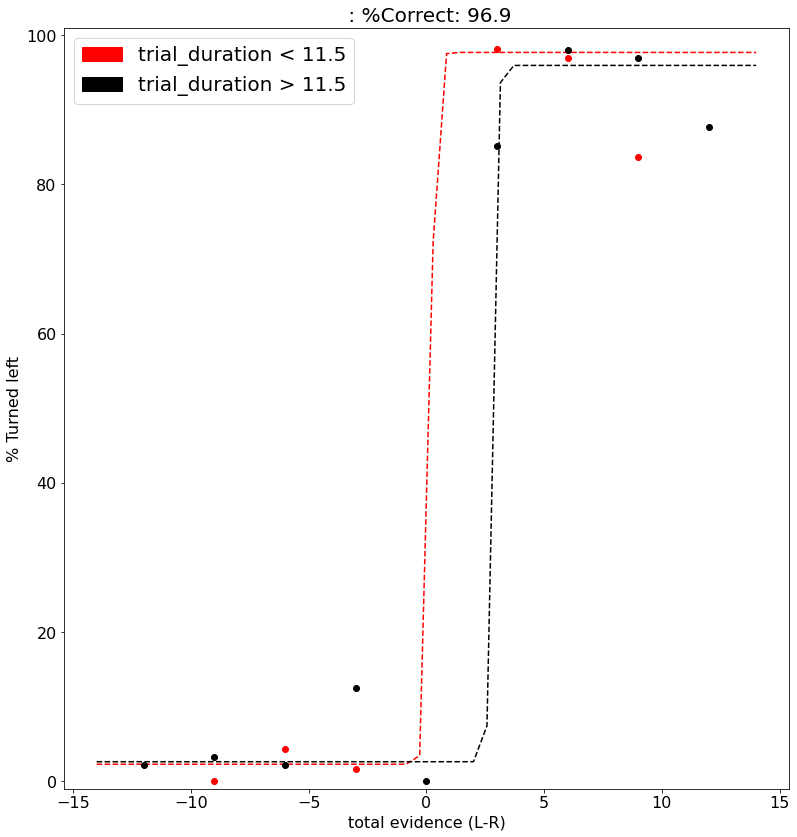

In [142]:
df_summary = pd.DataFrame(columns = [split_plots_by, 'Type', '%Correct', 'Total trials', 'Sigmoid fit'])

rows, cols = utility.get_cols_rows_plot(num_figs, fig_size)            
fig, axs = plt.subplots(rows, cols, figsize=fig_size, sharex=True, sharey=True, squeeze=False)
renderer = fig.canvas.get_renderer()

#Decide font size for plots
if num_figs >= 9:
    ac_fs = small_font_size
elif num_figs >= 5:
    ac_fs = medium_font_size
else:
    ac_fs = big_font_size

for split_idx, split in enumerate(plots_records):

    ac_col = split_idx%cols
    ac_row = int(split_idx/cols)
        
    #Create dictionary for split key plot (if applicable)
    split_key = dict()
    split_key[split_plots_by] = split

    for key_idx, key in enumerate(condition_key):

        #Fetch session info (if split, add split_key to query)
        if len(split_plots_by) > 0:
            thisCondition = data_table & table_filter.proj() & key & split_key
        else:
            thisCondition = data_table & table_filter.proj() & key
            
        # Fetch all fields of table except external (for speed)
        if key_idx == 0:
            fields_query = pd.DataFrame.from_dict(thisCondition.heading.attributes, orient='index')
            fields_query = fields_query.loc[fields_query['is_external'] == False, :]
            fields_query = fields_query.index.to_list()

        # Fetch session  
        session_info = pd.DataFrame(thisCondition.fetch(*fields_query, as_dict=True))

        # Choice and trial type as integer
        if session_info.shape[0] > 0:

            session_info = utility.translate_choice_trials_cues(session_info)

            # Call Fit to sigmoid function
            fit_dict = utility.psychFit(deltaBins, session_info['cue_presence_right'].values, \
                                session_info['cue_presence_left'].values, session_info['choice_int'].values)

            dict_summary = dict()
            dict_summary[split_plots_by]        =  split
            dict_summary['Type']         =  key
            dict_summary['%Correct']     =  np.sum(session_info['choice'].values == session_info['trial_type'].values)/session_info.shape[0]
            dict_summary['Total trials'] =  session_info.shape[0]
            dict_summary['Sigmoid fit']  =  fit_dict
            
            df_summary = df_summary.append(dict_summary, ignore_index = True)

            #Select color from color dictionary
            color_plot = color_dict_keys[key]
            #Plot results
            axs[ac_row, ac_col].plot(fit_dict['delta_bins'], fit_dict['pright_data'], 'o', color = color_plot)
            if fit_dict['delta_fit'].shape[0] > 0:
                axs[ac_row, ac_col].plot(fit_dict['delta_fit'], fit_dict['pright_fit'], '--', color = color_plot)
    
    # Axes, legends and labels
    if ac_col == 0:
        axs[ac_row, ac_col].set_ylabel("% Turned left", fontsize=ac_fs[1])
    
    axs[ac_row, ac_col].set_ylim([-1, 101])
    mean_correct_string = f"{df_summary.loc[df_summary[split_plots_by] == split, '%Correct'].mean()*100:2.1f}"
    if len(split_plots_by) > 7:
        title_label = str(split) + '-%Correct: ' + mean_correct_string
    else:
        title_label = split_plots_by + " : " + str(split) + '%Correct: ' + mean_correct_string
    axs[ac_row, ac_col].set_title(title_label, fontsize=ac_fs[0])
    
    fig.canvas.draw()
    plt.draw()    
    axs[ac_row, ac_col].draw(renderer)

    xlabels = axs[ac_row, ac_col].get_xticklabels()
    xlabels_t = [x.get_text() for x in xlabels]
    if len(xlabels) > 0:
        axs[ac_row, ac_col].set_xticklabels(xlabels, fontsize=ac_fs[1])
    ylabels = axs[ac_row, ac_col].get_yticklabels()
    ylabels_t = [x.get_text() for x in ylabels]
    if len(ylabels) > 0:
        axs[ac_row, ac_col].set_yticklabels(ylabels, fontsize=ac_fs[1])

for i in range(0,cols):
    axs[rows-1, i].set_xlabel("total evidence (L-R)", fontsize=ac_fs[1])
    
axs[rows-1, cols-1].legend(handles=patches_legend, fontsize=ac_fs[0])


## Summary DataFrame

In [143]:
mean_correct = df_summary['%Correct'].mean()
total_trials = df_summary['Total trials'].sum()

total_df = pd.DataFrame([['', 'Totals', mean_correct, total_trials, None]], columns=df_summary.columns)

df_final = df_summary.append(total_df, ignore_index=True)

if len(split_plots_by) > 0:
    df_final = df_final.set_index([split_plots_by, 'Type'])
else:
    df_final = df_final.set_index(['Type'])
df_final

,,%Correct,Total trials,Sigmoid fit
Type,,,,
trial_duration < 11.5,,0.974895,478,"{'delta_bins': [-9, -6, -3, 3, 6, 9], 'delta_d..."
trial_duration > 11.5,,0.962243,2728,"{'delta_bins': [-12, -9, -6, -3, 0, 3, 6, 9, 1..."
Totals,,0.968569,3206,None
